In [1]:
import pandas as pd
from textwrap import wrap
from matplotlib import rcParams
from matplotlib import cm
data = pd.read_csv('../processed_data/genesMappingPW.csv')

In [2]:
data.head()

,gene,pathways
0,SSA1,"['sce03040 Spliceosome', 'sce04141 Protein p..."
1,MDM10,['sce04139 Mitophagy - yeast']
2,CYS3,"['sce00260 Glycine, serine and threonine meta..."
3,SYN8,['sce04130 SNARE interactions in vesicular tr...
4,NTG1,['sce03410 Base excision repair']


In [3]:
data.pathways = data.pathways.apply(lambda x: eval(x))

In [4]:
import numpy as np
discreteP = np.hstack(data.pathways)
discreteP

array(['sce03040  Spliceosome',
       'sce04141  Protein processing in endoplasmic reticulum',
       'sce04144  Endocytosis', ..., 'sce01100  Metabolic pathways',
       'sce00470  D-Amino acid metabolism',
       'sce01100  Metabolic pathways'], dtype='<U64')

In [5]:
len(discreteP)

3939

In [6]:
len(data.gene)

1708

In [7]:
fiData = pd.read_excel('../raw_data/41592_2018_45_MOESM4_ESM.xlsx', skiprows=6, engine='openpyxl')
fiData = fiData.rename(columns={'Standard Name': 'gene'})[['gene', 'intensity']].dropna(axis=0)

/home/vaslem/code/intbioproj/.venv/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
fiData.head()

,gene,intensity
0,SSA1,11.906396
1,ERP2,0.299776
2,FUN14,0.455914
3,SPO7,0.027090
5,SWC3,0.031941


In [10]:
fiData['intensity']

0       11.906396
1        0.299776
2        0.455914
3        0.027090
5        0.031941
          ...    
5247     0.004747
5250     0.001582
5251     0.000000
5252     0.012131
5253     0.001582
Name: intensity, Length: 4342, dtype: float64

In [39]:
from sklearn.cluster import KMeans
# clusterLabels = KMeans(n_clusters=10).fit_predict(fiData['intensity'].values.reshape(-1, 1))
clusterLabels = np.digitize(fiData['intensity'].values, fiData['intensity'].quantile(np.linspace(0,1,10)).values) - 1
fiData['cluster'] = clusterLabels

In [40]:
fiData.clusterLabels = clusterLabels
visData = pd.merge(data, fiData, on='gene')
visData = visData.explode('pathways')
visData.head()

,gene,pathways,intensity,cluster
0,SSA1,sce03040 Spliceosome,11.906396,8
0,SSA1,sce04141 Protein processing in endoplasmic re...,11.906396,8
0,SSA1,sce04144 Endocytosis,11.906396,8
0,SSA1,sce04213 Longevity regulating pathway - multi...,11.906396,8
1,CYS3,"sce00260 Glycine, serine and threonine metabo...",0.583592,8


In [41]:
visData.shape

(3916, 4)

In [42]:
visData[visData['cluster'] == 0]

,gene,pathways,intensity,cluster
23,PHO11,sce00730 Thiamine metabolism,1.620746e-03,0
23,PHO11,sce00740 Riboflavin metabolism,1.620746e-03,0
23,PHO11,sce01100 Metabolic pathways,1.620746e-03,0
23,PHO11,sce04111 Cell cycle - yeast,1.620746e-03,0
49,TEL1,sce03440 Homologous recombination,5.782412e-19,0
...,...,...,...,...
1676,CLB5,sce04011 MAPK signaling pathway - yeast,1.845018e-03,0
1676,CLB5,sce04111 Cell cycle - yeast,1.845018e-03,0
1676,CLB5,sce04113 Meiosis - yeast,1.845018e-03,0
1681,ORC4,sce04111 Cell cycle - yeast,-2.618487e-04,0


In [43]:
visData.pathways = visData.pathways.apply(lambda x: ' '.join(x.split(' ')[1:]) )
visData.head()

,gene,pathways,intensity,cluster
0,SSA1,Spliceosome,11.906396,8
0,SSA1,Protein processing in endoplasmic reticulum,11.906396,8
0,SSA1,Endocytosis,11.906396,8
0,SSA1,Longevity regulating pathway - multiple species,11.906396,8
1,CYS3,"Glycine, serine and threonine metabolism",0.583592,8


In [44]:

freq = visData.groupby('pathways')['gene'].count()
freq

pathways
 2-Oxocarboxylic acid metabolism                28
 ABC transporters                               16
 Alanine, aspartate and glutamate metabolism    24
 Amino sugar and nucleotide sugar metabolism    28
 Aminoacyl-tRNA biosynthesis                    32
                                                ..
 Various types of N-glycan biosynthesis         27
 Vitamin B6 metabolism                           8
 alpha-Linolenic acid metabolism                 4
 beta-Alanine metabolism                        12
 mRNA surveillance pathway                      40
Name: gene, Length: 117, dtype: int64

In [45]:
freq = freq.sort_values(ascending=False)
freq.name = 'count'

In [46]:
freq.to_excel('../processed_data/known_genes_pathways_frequency.xlsx')

In [47]:
freq.iloc[:10]

pathways
 Metabolic pathways                             653
 Biosynthesis of secondary metabolites          295
 Cell cycle - yeast                             113
 Meiosis - yeast                                112
 Biosynthesis of cofactors                      112
 Biosynthesis of amino acids                    105
 Carbon metabolism                               95
 MAPK signaling pathway - yeast                  94
 Ribosome                                        93
 Protein processing in endoplasmic reticulum     84
Name: count, dtype: int64

In [48]:
# keep the 10 most frequent pathways
visDataSubset = visData[visData['pathways'].isin(freq.iloc[:10].index)]
visDataSubset = visDataSubset.sort_values('intensity', ascending=False)
cDescriptions = visDataSubset.groupby('cluster')['gene'].agg(
    lambda x: ','.join([y.strip() for y in list(dict.fromkeys(x))])[:96].split(','))
cDescriptions.name = 'desc'
cMinInt = visDataSubset.groupby('cluster')['intensity'].agg(min)
cMaxInt = visDataSubset.groupby('cluster')['intensity'].agg(max)

included = cDescriptions.explode()
included.name = 'gene'
included = included.reset_index()
included = visDataSubset.merge(included, on=['gene', 'cluster'], how='outer', indicator=True)
notIncluded = included[included._merge == 'left_only']
notIncluded = notIncluded[['cluster','gene']].drop_duplicates()
notIncludedCnts = notIncluded.groupby('cluster')['gene'].agg('count')

In [49]:
notIncludedCnts

cluster
0     87
1     72
2     78
3     51
4     61
5     73
6    109
7    125
8    248
Name: gene, dtype: int64

In [50]:
shownInDesc = cDescriptions.explode()
shownInDesc

cluster
0     SPE1
0     APC2
0     DIE2
0     SPR3
0     DAL7
     ...  
8    RPP2A
8     ACO1
8     PMA1
8       AC
9     TDH3
Name: desc, Length: 170, dtype: object

In [51]:
visDataSubset

,gene,pathways,intensity,cluster
683,TDH3,Metabolic pathways,34.702548,9
683,TDH3,Biosynthesis of secondary metabolites,34.702548,9
683,TDH3,Carbon metabolism,34.702548,9
683,TDH3,Biosynthesis of amino acids,34.702548,9
1049,PDC1,Biosynthesis of secondary metabolites,33.823165,8
...,...,...,...,...
831,IMA3,Metabolic pathways,-0.002546,0
837,DAL2,Metabolic pathways,-0.002787,0
182,MPS1,Cell cycle - yeast,-0.003121,0
834,FLO11,MAPK signaling pathway - yeast,-0.003344,0


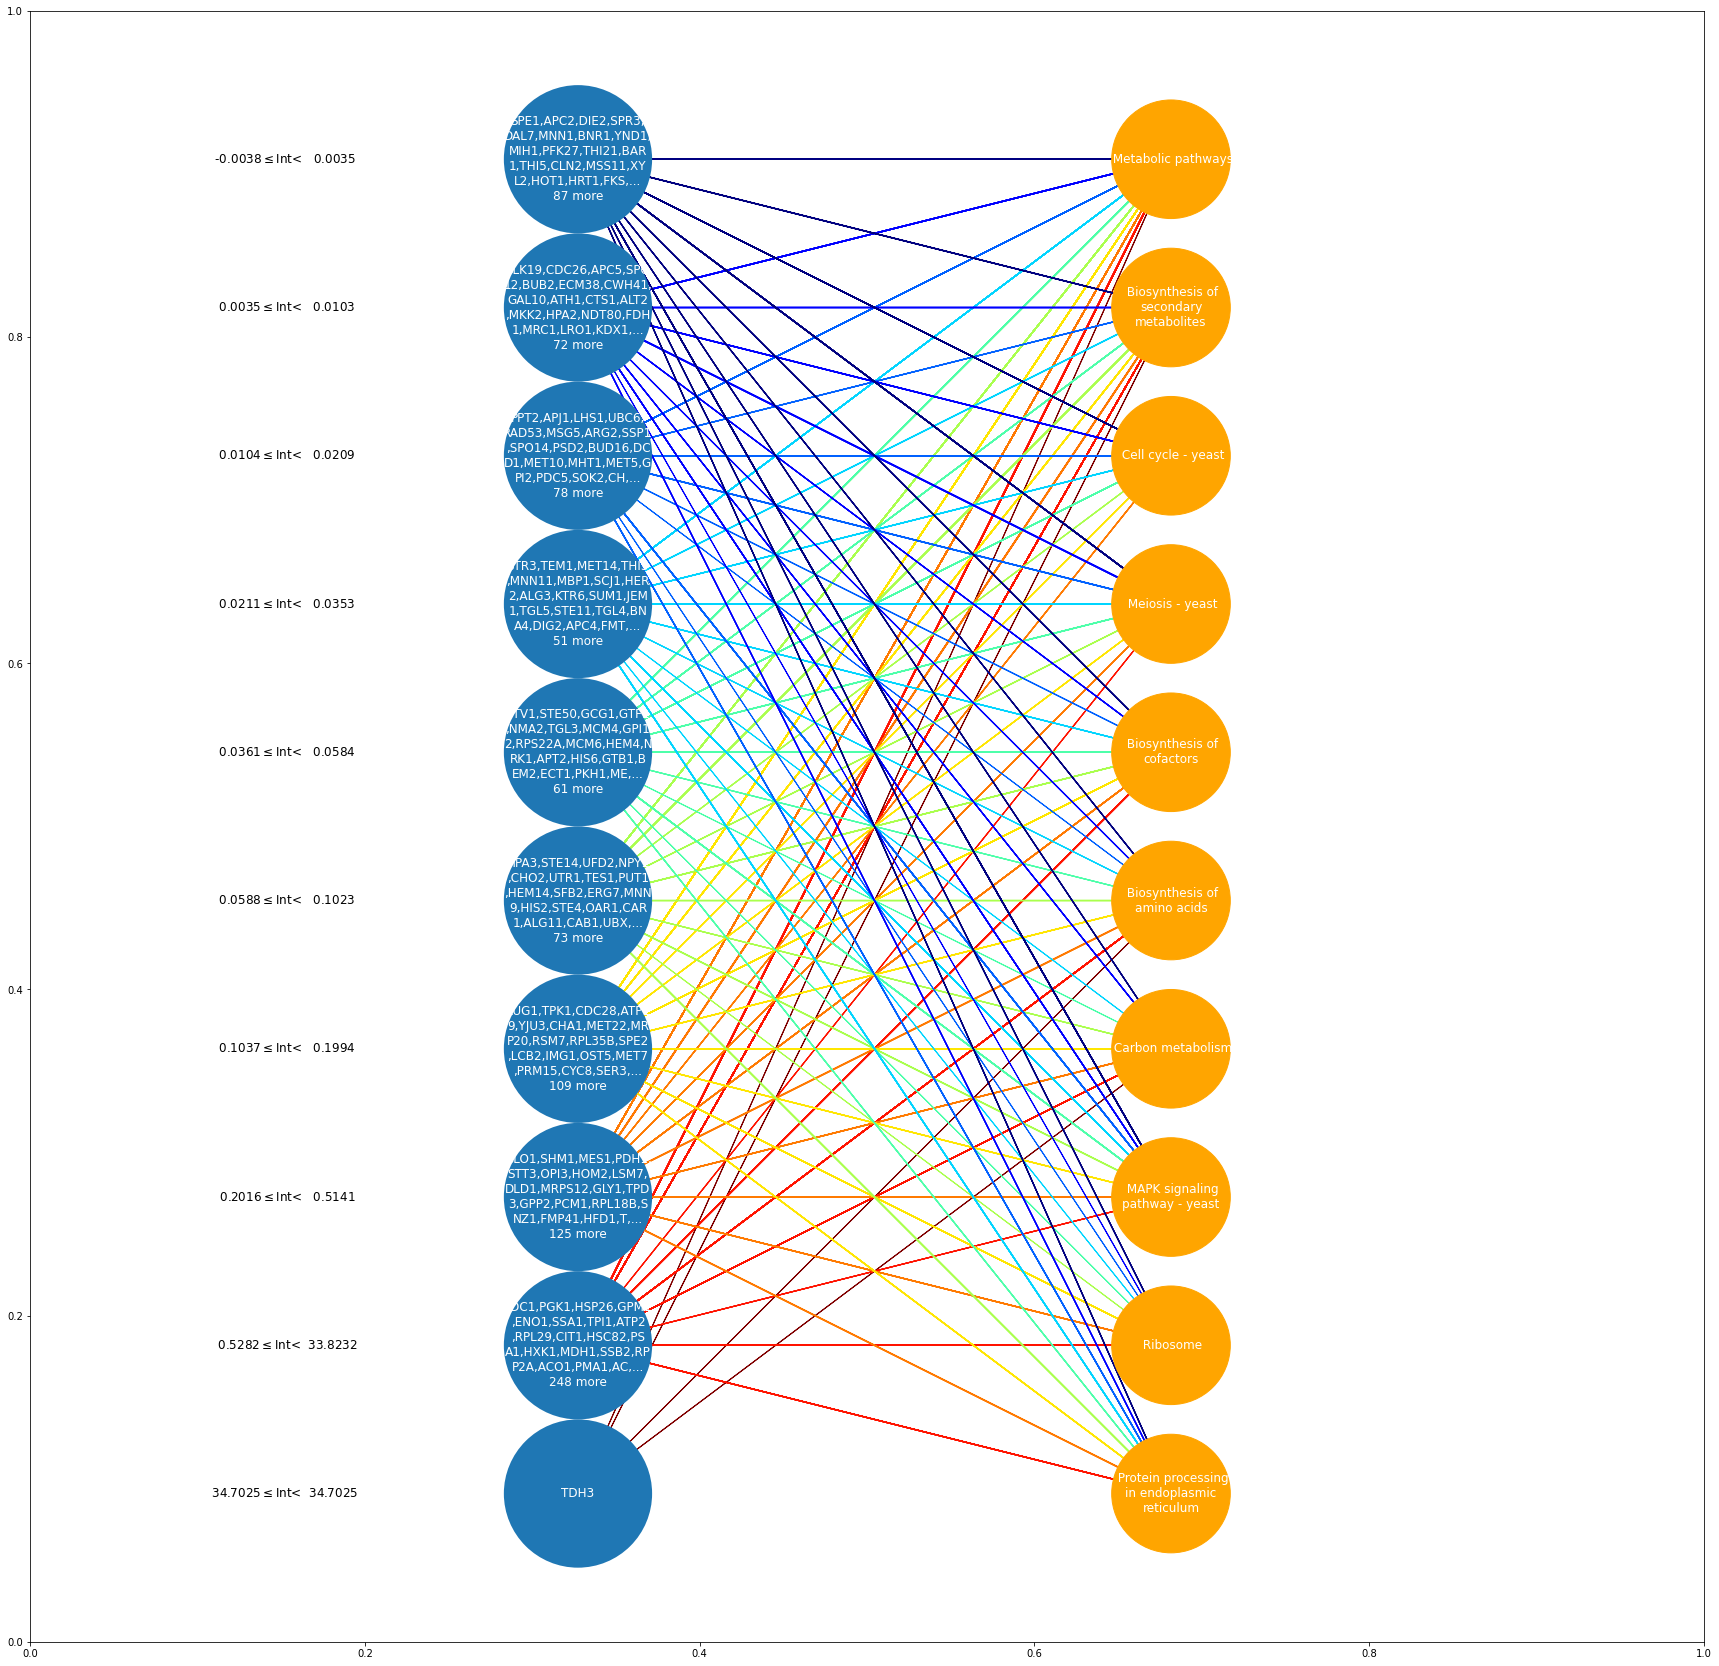

In [82]:

import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(30,30))

ax = fig.add_subplot(111)

x = 100
y = 0

gradient = np.linspace(0, 1, 10)
path_coords = {}
clusters_coords = {}
rgb = cm.get_cmap('jet')(gradient)[np.newaxis, :, :3]
for cluster in range(9,-1,-1):
    y += 50
    clusters_coords[cluster] = y
y = 0
for path in range(9,-1,-1):
    y += 50
    path_coords[path] = y
    
for _, line in visDataSubset.iterrows():
    
    gradient[line['cluster']]
    plt.arrow(x=100, y=clusters_coords[line['cluster']], color=rgb[:, line['cluster'], :].flatten(),
              dx=200, dy=path_coords[np.where(freq.index == line['pathways'])[0][0]] - clusters_coords[line['cluster']], width=.06)
    
    
    

for cluster in range(9,-1,-1):
    y = clusters_coords[cluster]
    circle = plt.Circle((x, y), radius=25)
    ax.add_patch(circle)
    ax.text( x=0, y=y , s=f'{cMinInt[cluster]:9.4f}' r'$\leq$' 'Int' r'<' f'{cMaxInt[cluster]:9.4f}', 
            fontsize=12, 
                verticalalignment='center', horizontalalignment='center', color='black')
    
    ax.annotate('\n'.join(wrap(','.join(cDescriptions[cluster]) + 
                               
                               (f',...{notIncludedCnts[cluster]} more' if cluster in notIncludedCnts else '')
                               
                               , width=20)), xy=(x, y), fontsize=12, 
                verticalalignment='center', horizontalalignment='center', color='white')

x = 300

for path in range(9,-1,-1):
    y = path_coords[path]
    circle = plt.Circle((x, y), radius=20, color='orange')
    ax.add_patch(circle)
    ax.annotate('\n'.join(wrap(freq.index[path], width=20)), xy=(x, y), fontsize=12, 
                verticalalignment='center', horizontalalignment='center', color='white')

ax.axis('off')
ax.set_aspect('equal')
ax.autoscale_view()

plt.show()

In [ ]:
fig.savefig("../figures/pathways_mapping.png")